In [10]:
%matplotlib inline

In [299]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from math import ceil, log
import ipywidgets as widgets

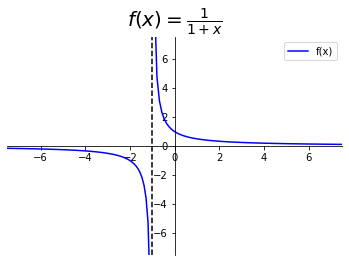

In [300]:
@njit(parallel=True)
def f(x):
    return 1 / (1 + x)

@njit(parallel=True)
def realValue(a, b):
    return log((1 + b) / (1 + a))

x_neg = np.linspace(-10, -1.1, 100)
x_pos = np.linspace(-0.9, 10, 100)
y_neg = f(x_neg)
y_pos = f(x_pos)

ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('data',0))
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data',0))

plt.xlim(-7.5, 7.5)
plt.ylim(-7.5, 7.5)

plt.plot(x_neg, y_neg, "b", label="f(x)")
plt.plot(x_pos, y_pos, "b")
plt.axvline(-1, linestyle="dashed", color="k")

plt.legend()
plt.title(r"$f(x)=\frac{1}{1+x}$", fontsize=20)
fig = plt.gcf()

### Metodo dei Punti Medi
Sia $y=f(x)$ definita, continua e positiva o nulla in $[a, b]$<br>
Suddividiamo l'intervallo $[a, b]$ in $n$ sottointervalli di ampiezza $h=\frac{b-a}{n}$<br>
Prendiamo in considerazione $n$ rettangoli di altezza pari al valore assunto dalla funzione nel punto medio di ogni intervallo<br>
Approssimiamo l'area del trapezoide $T$ con la somma delle aree dei rettangoli:
\begin{align}
A(T) \simeq h \cdot f(\overline{x}_1) + h \cdot f(\overline{x}_2) + ... + h \cdot f(\overline{x}_i) = A(R_M)
\end{align}
Dove $\overline{x}_i$ è il punto medio di $[x_{i-1}, x_i]$<br>
Se aumentiamo il numero di suddivisioni di $[a, b]$ otteniamo la formula generale:
\begin{align}
A(T) \simeq A(R_M) = h \cdot \sum_{i = 1}^{n} f(\overline{x}_i)
\end{align}
\begin{align}
h = \frac{b-a}{n}
\end{align}
\begin{align}
\overline{x}_i = \frac{x_{i-1} + x_i}{2}
\end{align}

In [331]:
@njit(parallel=True)
def midpoint(i, n):
    h = (i[1] - i[0]) / n
    x = np.linspace(i[0], i[1], n + 1)
    x_mid = (x[:-1] + x[1:]) / 2
    s = np.sum(f(x_mid)) * h
    print("Real Value:\t\t", realValue(i[0], i[1]))
    print("Approximated Value:\t", s)

mid = widgets.interact_manual(
    midpoint,
    i=widgets.FloatRangeSlider(
        min=0, 
        max=100, 
        value=[0, 1], 
        description="$[a, b]:$",
        layout=widgets.Layout(width="50%")
    ), 
    n=widgets.IntSlider(
        min=1, 
        max=1e8, 
        value=10,
        description="$n: $",
        layout=widgets.Layout(width="50%")
    )
)

interactive(children=(FloatRangeSlider(value=(0.0, 1.0), description='$[a, b]:$', layout=Layout(width='50%')),…

### Metodo dei Trapezi
Sia $y=f(x)$ definita, continua e positiva o nulla in $[a, b]$<br>
Suddividiamo l'intervallo $[a, b]$ in $n$ sottoinsiemi e approssimiamo ogni arco con una funzione lineare.<br>
L'integrale in questo modo è approssimato dalla somma delle aree di $n$ trapezi.<br>
Indichiamo con $h = \frac{b - a}{n}$ l'altezza dei trapezi, allora l'area di un trapezio di base $[x_{i-1}, x_i]$ è:
\begin{align}
A_i = \frac{\left[f(x_i) + f(x_{i-1})\right] \cdot h}{2}
\end{align}
Sommando le aree di tutti i trapezi otteniamo la formula composita:
\begin{align}
A(T) \simeq \frac{h}{2} \cdot \sum_{i = 1}^{n}\left[f(x_i) + f(x_{i - 1})\right] = \frac{h}{2} \cdot \left[f(a) + 2\sum_{i = 1}^{n - 1}f(x_i) + f(b)\right]
\end{align}
\begin{align}
h = \frac{b - a}{n}
\end{align}

In [332]:
@njit(parallel=True)
def trapezoid(i, n):
    h = (i[1] - i[0]) / n
    x = np.linspace(i[0], i[1], n + 1)
    s = f(i[0]) + (2 * np.sum(f(x[1:-1]))) + f(i[1])
    s *= h
    s /= 2
    print("Real Value:\t\t", realValue(i[0], i[1]))
    print("Approximated Value:\t", s)

trap = widgets.interact_manual(
    trapezoid,
    i=widgets.FloatRangeSlider(
        min=0, 
        max=100, 
        value=[0, 1], 
        description="$[a, b]:$",
        layout=widgets.Layout(width="50%")
    ), 
    n=widgets.IntSlider(
        min=1, 
        max=1e8, 
        value=10,
        description="$n: $",
        layout=widgets.Layout(width="50%")
    )
)

interactive(children=(FloatRangeSlider(value=(0.0, 1.0), description='$[a, b]:$', layout=Layout(width='50%')),…

### Metodo di Cavalieri-Simpson
Il metodo di Cavalieri-Simpson approssima la funzione con una funzione razionale intera di secondo grado $y = Ax^2 + Bx + C$.<br>
I coefficienti $A, B, C$ possono essere determinati connoscendo 3 punti di passaggio della parabola.<br>
Dividendo l'intervallo di integrazione $[a, b]$ in 2 parti si ottengono i 3 punti per cui passa la parabola: $P(x_0, y_0), Q(x_1, y_1), R(x_2, y_2)$ con $a = x_0$ e $b = x_2$<br>
Per semplificare i calcoli possiamo traslare la parabola in modo che $Q$ si trovi sull'asse $y$.<br>
L'area cercata è:
\begin{align}
\int_{-h}^{h}\left(Ax^2 + Bx + C\right)dx = \int_{-h}^{h}Ax^2dx + \int_{-h}^{h}Bxdx + \int_{-h}^{h}Cdx = \left[A\frac{x^3}{3}\right]^h_{-h} + \left[B\frac{x^2}{2}\right]^h_{-h} + \left[Cx\right]^h_{-h} = 2A\frac{h^3}{3} + 2Ch 
\end{align}
Indichiamo con $y = g(x)$ l'equazione della parabola con $Q$ appartenente all'asse $y$.<br>
\begin{align}
P(-h, y_0) \longrightarrow g(-h) = Ah^2 - Bh + C \longrightarrow Ah^2 - Bh + C = y_0
\end{align}
\begin{align}
R(h, y_2) \longrightarrow g(h) = Ah^2 + Bh + C \longrightarrow Ah^2 + Bh + C = y_2
\end{align}
\begin{align}
y_0 + y_2 = 2Ah^2 + 2C
\end{align}
\begin{align}
Q(0, y_1) \longrightarrow g(0) = C \longrightarrow C = y_1
\end{align}
\begin{align}
y_0 + y_2 = 2Ah^2 + 2y_1 \Rightarrow 2Ah^2 = y_0 - 2y_1 + y_2
\end{align}<br>
Area cercata $= 2A\frac{h^3}{3} + 2Ch = \frac{h}{3}\left[2Ah^2 + 6C\right] = \frac{h}{3}\left[y_0 - 2y_1 + y_2 + 6y_1\right] = \frac{h}{3}\left[y_0 + 4y_1 + y_2\right]$<br>
Suddividendo l'intervallo $[a, b]$ in $n$ sottointervalli e applicando questa formula ad ogni coppia di intervalli consecutivi, otteniamo la formula composita:
\begin{align}
A(T) \simeq \frac{h}{3}\left(y_0 + 4y_1 + y_2\right) + \frac{h}{3}\left(y_2 + 4y_3 + y_4\right) + ... + \frac{h}{3}\left(y_{(2\lceil\frac{n}{2}\rceil - 2)} + 4y_{(2\lceil\frac{n}{2}\rceil - 1)} + y_{(2\lceil\frac{n}{2}\rceil)}\right) = \frac{h}{3}\left[y_0 + 4y_1 + 2y_2 + 4y_3 + 2y_4 + ... + 2y_{(2\lceil\frac{n}{2}\rceil - 2)} + 4y_{(2\lceil\frac{n}{2}\rceil - 1)} + 2y_{(2\lceil\frac{n}{2}\rceil)}\right] = \frac{h}{3}\left[a + 4\sum_{i = 1}^{\lceil\frac{n}{2}\rceil}y_{2i - 1} + 2\sum_{i = 1}^{\lceil\frac{n}{2}\rceil - 1}y_{2i} + b\right]
\end{align}

In [333]:
@njit(parallel=True)
def simpson(i, n):
    n = (2 * ceil(n / 2))
    h = (i[1] - i[0]) / n
    x = np.linspace(i[0], i[1], n + 1)
    s = f(i[0]) + (4 * np.sum(f(x[1::2]))) + (2 * np.sum(f(x[2:-1:2]))) + f(i[1])
    s *= h
    s /= 3
    print("Real Value:\t\t", realValue(i[0], i[1]))
    print("Approximated Value:\t", s)
    
simp = widgets.interact_manual(
    simpson,
    i=widgets.FloatRangeSlider(
        min=0, 
        max=100, 
        value=[0, 1], 
        description="$[a, b]:$",
        layout=widgets.Layout(width="50%")
    ), 
    n=widgets.IntSlider(
        min=2, 
        max=1e8, 
        step=2, 
        value=10,
        description="$n: $",
        layout=widgets.Layout(width="50%")
    )
)

interactive(children=(FloatRangeSlider(value=(0.0, 1.0), description='$[a, b]:$', layout=Layout(width='50%')),…